<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
    <img style="float: right; padding-right: 10px; width: 65px" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>


## Homework 7: Neural Networks

**Clemson University**<br>
**Spring 2023**<br>
**Instructor(s):** Carlos Toxtli & Nina Hubig <br>
**Author(s):** Brandon Walker

---

In [17]:
""" RUN THIS CELL TO GET THE RIGHT FORMATTING """
import requests
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/css/cpsc6300.css'
styles = requests.get(css_file).text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and are aiming to teach. And, if a problem specifies a particular library, you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

Instructions for installing Tensorflow using pip https://www.tensorflow.org/install/pip

In [18]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

# from sklearn.utils import shuffle

In [19]:
# TensorFlow and tf.keras
import tensorflow as tf

print(tf.__version__)

2.9.1


<div class='theme'> Neural Networks</div> 

Neural networks are, of course, a large and complex topic that cannot be covered in a single homework. Here, we'll focus on the key idea of ANNs: they are able to learn a mapping from example input data $X$ (of fixed size) to example output data $Y$ (of fixed size). This is the same concept as every other classification and regression task we've learned so far in the semester. We'll also partially explore what patterns the neural network learns and how well neural networks generalize.

In this question, we'll see if neural networks can learn a limited version of the [Fourier Transform.](https://en.wikipedia.org/wiki/Fourier_transform) (The Fourier Transform takes in values from some function and returns a set of sine and cosine functions which, when added together, approximate the original function.)

In symbols: $ \cal{F(s)} = \int_{-\infty}^\infty f(x)e^{- i xs}dx$. In words, the value of the transformed function at some point, $s$, is the value of an integral which measures, in some sense, how much the original $f(x)$ looks like a wave with a period of $s$. As an example, with $f(x) = 4cos(x) + sin(2x)$,  $\cal{F}(s)$ is 0 everywhere except at -2, -1, 1, and 2, mapping to the waves of period 1 and 1/2. The values at these points are linked to the magnitude of the waves, and their phases (roughly: sin waves versus cosine waves).

The only thing about the Fourier transform that matters for this p-set is this: a function goes in, and a re-written form in terms of sine and cosine comes out.

In our specific problem, we'll train a network to map from 1000 sample values from a function (equally spaced along 0 to 10$\pi$) to the four features of the sine and cosine waves that make up that function. Thus, the network is attempting to learn a mapping from a 1000-entry vector down to a 4-entry vector. Our `X_train` dataset's shape is $N x 1000$ and our `y_train` is $N x 4.$

Questions 1.1 and 1.2 will get you used to the format of the data. 

We'll use 6 data files in this question:
- `sinewaves_X_train.npy` and `sinewaves_y_train.npy`: a (10,000 x 1,000) and (10,000 x 4) training dataset. Examples were generated by randomly selecting a,b,c,d in the interval [0,1] and building the curve $a\sin(b\,x) + c\cos(d\,x)$
- `sinewaves_X_test.npy` and `sinewaves_y_test.npy`: a (2,000 x 1,000) and (2,000 x 4) test dataset, generated in the same way as the training data
- `sinewaves_X_extended_test` and `sinewaves_y_extended_test`: a (9 x 1,000) and (9 x 4) test dataset, testing whether the network can generalize beyond the training data (e.g. to negative values of $a$)

**These datasets are read in to their respective variables for you.**

**Hint**:
- The Tensorflow [`tf.keras` (here)](https://www.tensorflow.org/guide/keras) documentation and examples of a Sequential model are a good place to start.
- A strong model can achieve validation error of around 0.03 on this data and 0.02 is very good.

In [20]:
def plot_predictions(model, test_x, test_y, count=None):
    # Model - a tf.keras model that takes in (n,1000) training data and predicts (n,4) output data
    # test_x - a (n,1000) input dataset
    # test_y - a (n,4) output dataset
    # This function will plot the sine curves in the training data and those implied by the model's predictions.
    # It will also print the predicted and actual output values.
    
    #helper function that takes the n by 4 output and reverse-engineers 
    #the sine curves that output would create
    def y2x(y_data):
        #extract parameters
        a=y_data[:,0].reshape(-1,1)
        b=y_data[:,1].reshape(-1,1)
        c=y_data[:,2].reshape(-1,1)
        d=y_data[:,3].reshape(-1,1)

        #build the matching training data
        x_points = np.linspace(0,10*np.pi,1000)
        x_data = a*np.sin(np.outer(b,x_points)) + c*np.cos(np.outer(d,x_points))
        return x_data
    
    #if <20 examples, plot all. If more, just plot 5
    if count==None:
        if test_x.shape[0]>20:
            count=5
        else:
            count=test_x.shape[0]
    
    #build predictions
    predicted = model.predict(test_x)
    implied_x = y2x(predicted)
    for i in range(count):
        plt.plot(test_x[i,:],label='true')
        plt.plot(implied_x[i,:],label='predicted')
        plt.legend()
        plt.ylim(-2.1,2.1)
        plt.xlabel("x value")
        plt.xlabel("y value")
        plt.title("Curves using the Neural Network's Approximate Fourier Transform")
        plt.show()
        print("true:", test_y[i,:])
        print("predicted:", predicted[i,:])
    
    

In [21]:
X_train = np.load('sinewaves_X_train.npy')
y_train = np.load('sinewaves_y_train.npy')

X_test = np.load('sinewaves_X_test.npy')
y_test = np.load('sinewaves_y_test.npy')

X_extended_test = np.load('sinewaves_X_extended_test.npy')
y_extended_test = np.load('sinewaves_y_extended_test.npy')

<hr style='height:2pt'>

<div class='exercise'> <b> Question 1 </b> </div>
Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

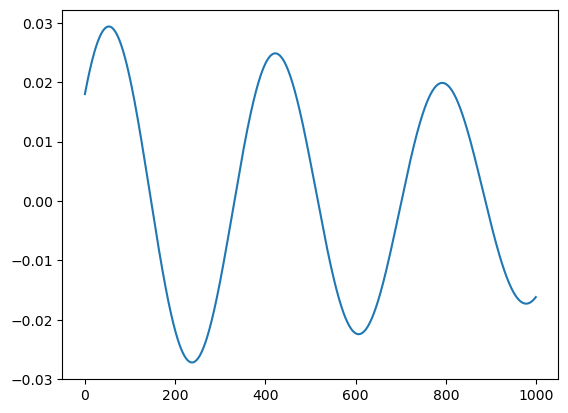

In [22]:
# your code here
plt.plot(X_train[0])

<div class='exercise'> <b> Question 2 </b> </div>

The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually verify that the first row of X_train is 1000 equally-spaced points in $[0,10\pi]$ from the function $f(x) = 0.024\sin(0.533\,x) + 0.018\cos(0.558\,x)$

In [23]:
# your code here
y_train[0]

array([0.024, 0.533, 0.018, 0.558])

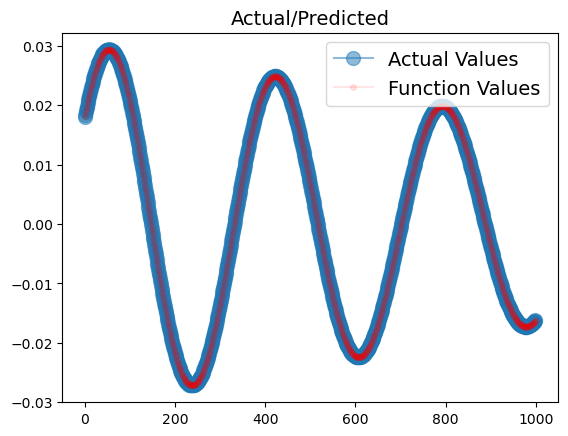

In [24]:
# your code here 
import math
f_x = []
v = np.arange(0,10*math.pi+(10*math.pi)/1000,(10*math.pi)/1000)
for i in (v):
    value = 0.024*math.sin(0.533*i) + 0.018*math.cos(0.558*i)
    f_x.append(value)
plt.plot(X_train[0],alpha= 0.5,marker="o", markersize=10,label = 'Actual Values')
plt.plot(f_x,alpha = 0.1 ,marker=".", markersize=8, label = 'Function Values',color = 'red')

plt.title('Actual/Predicted', fontsize=14)
plt.legend(loc='best', fontsize=14);

<div class='exercise'> <b> Question 3 </b> </div>
Use `tf.keras` to build a fully-connected neural network:

**a:** Use `tf.keras.models.Sequential` and `tf.keras.layers.Dense` to build the fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. Remember that as a regression problem, the last layer activation should be `linear`.

**b:** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

**c:** Fit your model to the data for $50$ epochs using a batch size of $32$ and a validation split of $0.2$. You can train for longer if you wish -- the fit tends to improve over time.


In [25]:
# build the fully-connected neural network
# your code here
model = tf.keras.models.Sequential([

    tf.keras.layers.Dense(512, activation='relu',input_shape=(1000,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu')
])

In [26]:
# Compile your model 
# your code here
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               512512    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 16)                4112      
                                                                 
 dense_7 (Dense)             (None, 4)                 68        
                                                                 
Total params: 648,020
Trainable params: 648,020
Non-trainable params: 0
_________________________________________________________________


*your answer here*
There are 25025 params in the first layer. This is due to we have around 10000 values as input.



In [27]:
# Fit your model 
# your code here
history = model.fit(X_train, 
                    y_train, 
                    validation_split=0.2, 
                    epochs=50, batch_size=32,
                    verbose=2)

Epoch 1/50
250/250 - 1s - loss: 0.1928 - val_loss: 0.1180 - 1s/epoch - 4ms/step
Epoch 2/50
250/250 - 1s - loss: 0.0995 - val_loss: 0.0867 - 767ms/epoch - 3ms/step
Epoch 3/50
250/250 - 1s - loss: 0.0789 - val_loss: 0.0734 - 788ms/epoch - 3ms/step
Epoch 4/50
250/250 - 1s - loss: 0.0706 - val_loss: 0.0661 - 784ms/epoch - 3ms/step
Epoch 5/50
250/250 - 1s - loss: 0.0631 - val_loss: 0.0613 - 766ms/epoch - 3ms/step
Epoch 6/50
250/250 - 1s - loss: 0.0592 - val_loss: 0.0556 - 773ms/epoch - 3ms/step
Epoch 7/50
250/250 - 1s - loss: 0.0548 - val_loss: 0.0514 - 763ms/epoch - 3ms/step
Epoch 8/50
250/250 - 1s - loss: 0.0523 - val_loss: 0.0521 - 763ms/epoch - 3ms/step
Epoch 9/50
250/250 - 1s - loss: 0.0482 - val_loss: 0.0464 - 763ms/epoch - 3ms/step
Epoch 10/50
250/250 - 1s - loss: 0.0464 - val_loss: 0.0436 - 761ms/epoch - 3ms/step
Epoch 11/50
250/250 - 1s - loss: 0.0434 - val_loss: 0.0430 - 762ms/epoch - 3ms/step
Epoch 12/50
250/250 - 1s - loss: 0.0420 - val_loss: 0.0465 - 758ms/epoch - 3ms/step
Epoc

<div class='exercise'> <b> Question 4 </b> </div>

Use the `plot_predictions` function to plot the model's predictions on `X_test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefecients that generated the data?

63/63 [==============================] - 0s 2ms/step


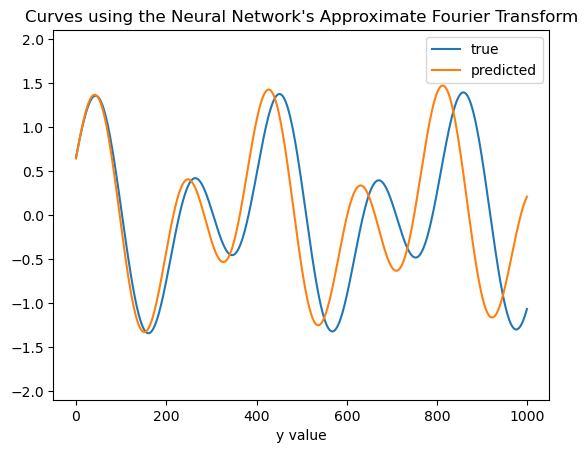

true: [0.86199664 0.98175913 0.65523998 0.4870337 ]
predicted: [0.8784276  1.0402557  0.6421806  0.50627375]


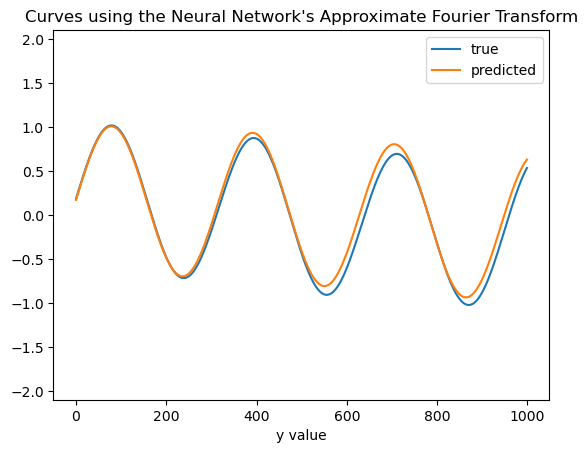

true: [0.8406355  0.63159555 0.18328701 0.11174618]
predicted: [0.8392934  0.6367272  0.17063746 0.08029342]


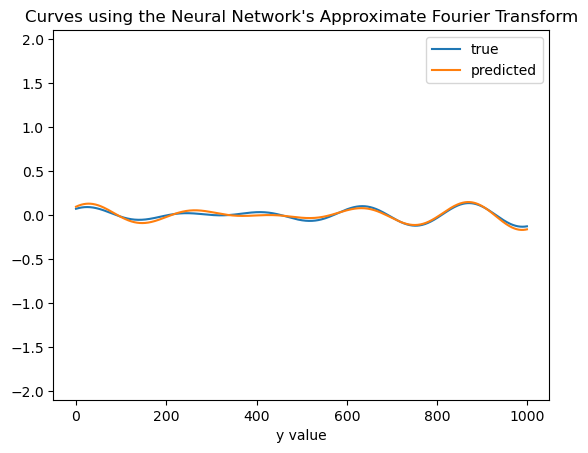

true: [0.06591224 0.75183886 0.06986143 0.91352303]
predicted: [0.098673   0.7742069  0.09343439 0.8951457 ]


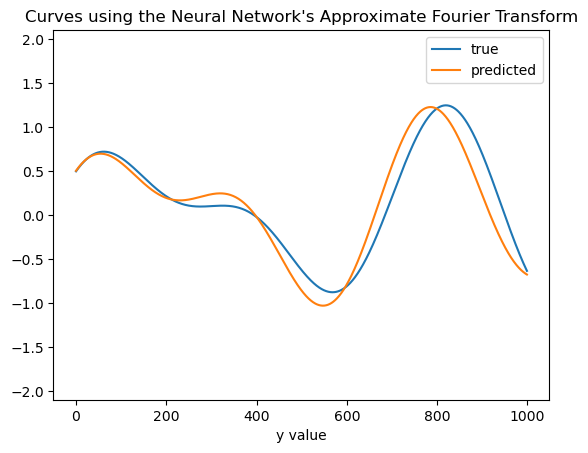

true: [0.75610725 0.30861152 0.49522059 0.48394499]
predicted: [0.7450734 0.3102313 0.5016654 0.5156856]


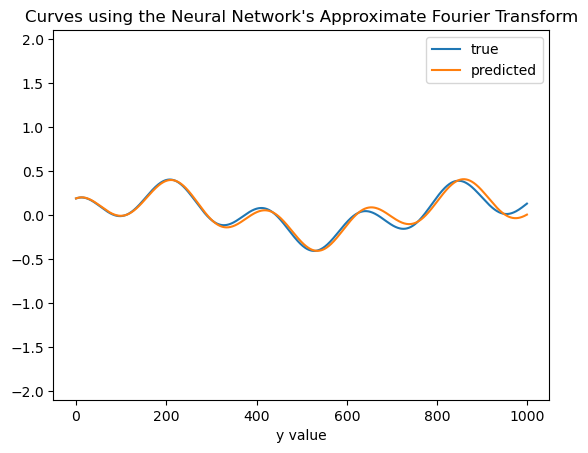

true: [0.2229353  0.27885697 0.18696198 0.94846283]
predicted: [0.22173627 0.28487313 0.18728913 0.9324899 ]


In [28]:
# your code here
plot_predictions(model,X_test,y_test)

In [29]:
# model's overall loss
# your code here
model.evaluate(X_test,y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.0245


0.0245242640376091

*your answer here*
The model performs relatively good on the test/unseen data set as we can see that the overall loss observed by using Mean absolute error across the test data set observed is 0.278 which is a good value.

----

<div class='exercise'> <b> Question 5 </b> </div>
Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

1/1 [==============================] - 0s 13ms/step


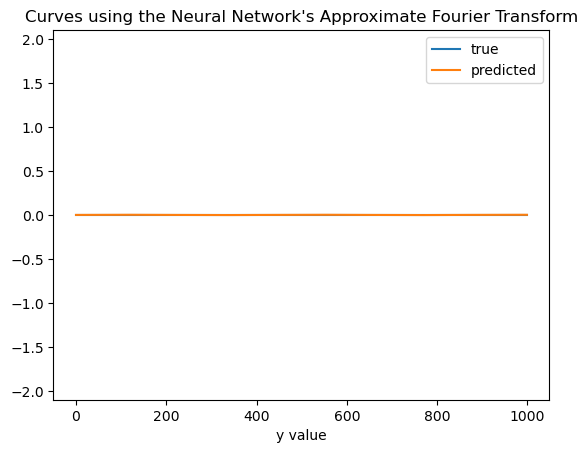

true: [0. 0. 0. 0.]
predicted: [0.0015869 0.4629712 0.        0.4951262]


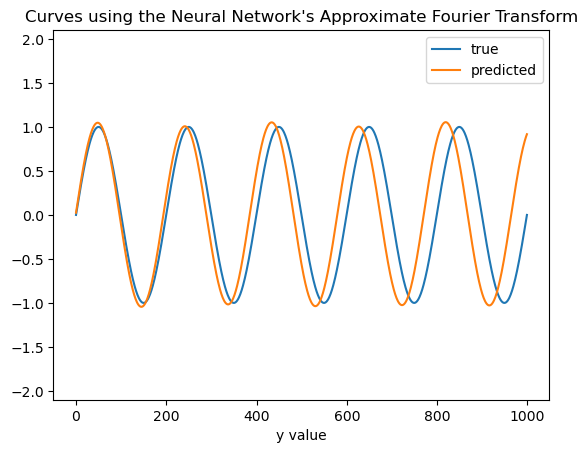

true: [1. 1. 0. 0.]
predicted: [1.0288596  1.0367777  0.02530856 0.49059418]


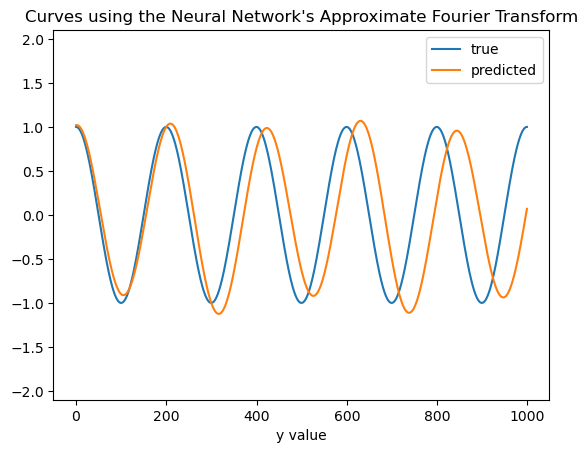

true: [0. 0. 1. 1.]
predicted: [0.10779281 0.45096356 1.0195408  0.94879365]


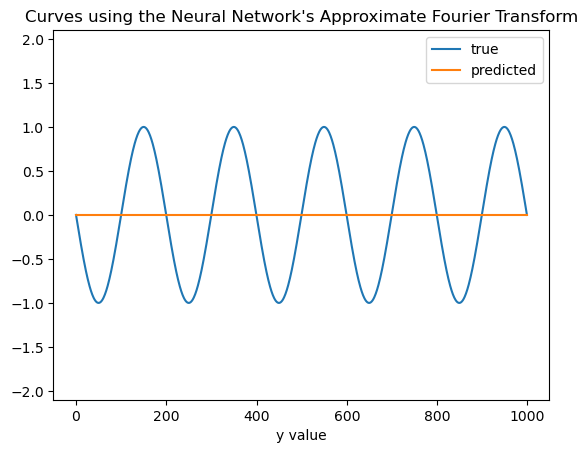

true: [-1.  1.  0.  0.]
predicted: [1.3944526 0.        0.        0.9991591]


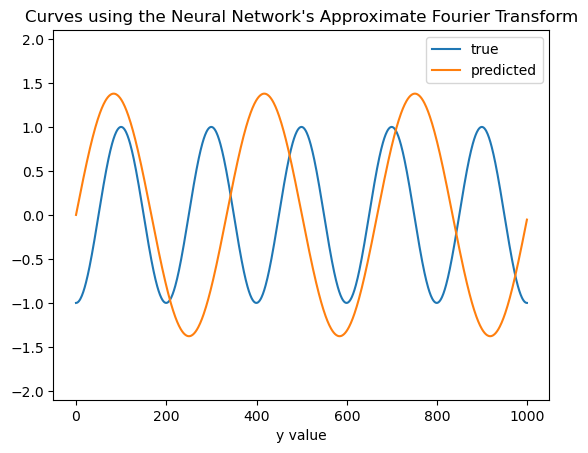

true: [ 0.  0. -1.  1.]
predicted: [1.3781902 0.5987683 0.        0.8642908]


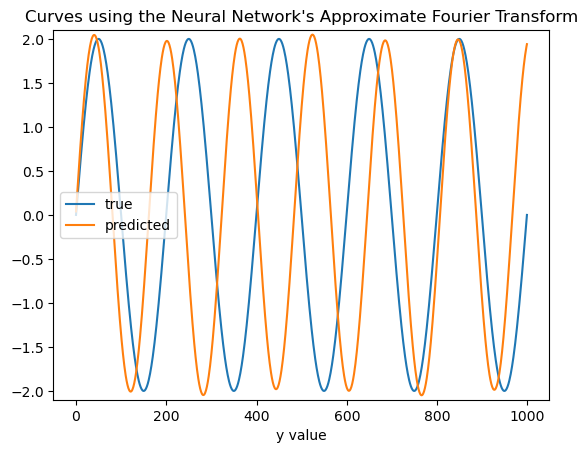

true: [2. 1. 0. 0.]
predicted: [2.009863   1.2394547  0.04013272 0.39803582]


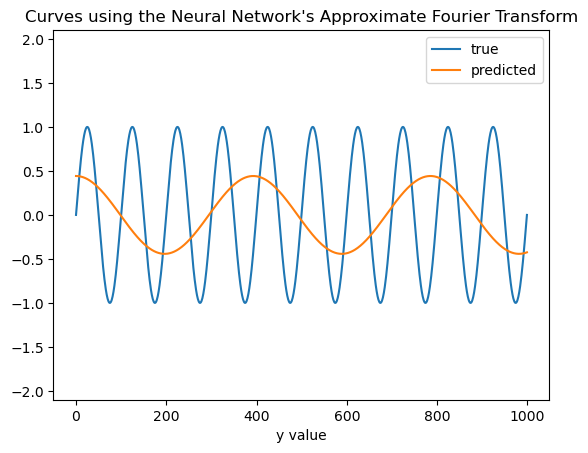

true: [1. 2. 0. 0.]
predicted: [0.         0.         0.44229227 0.5089292 ]


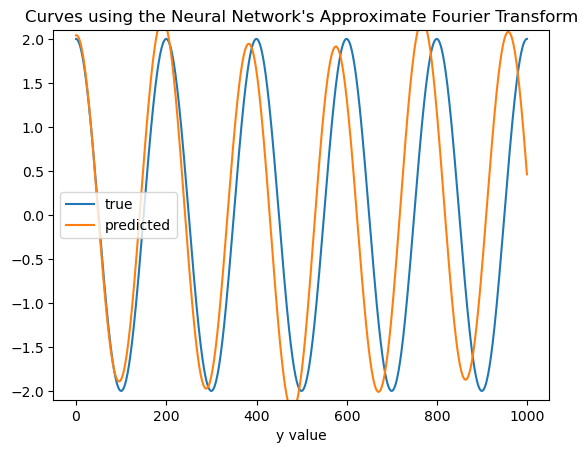

true: [0. 0. 2. 1.]
predicted: [0.18708642 0.3057248  2.0412023  1.0422072 ]


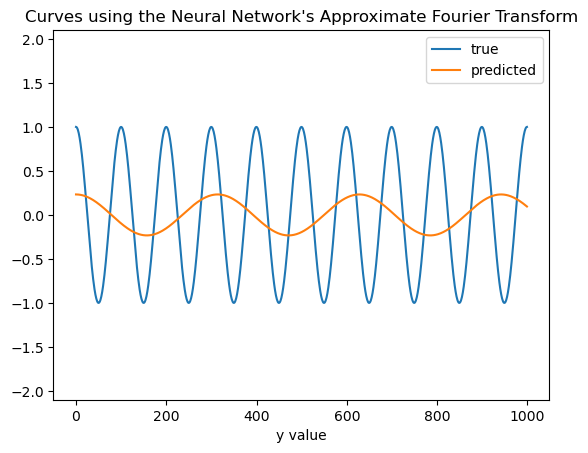

true: [0. 0. 1. 2.]
predicted: [0.7109989  0.         0.23274396 0.6365094 ]


In [30]:
# your code here
plot_predictions(model,X_extended_test,y_extended_test)

*Your answer here*
After evaluating the model performance on 9 pairs, model two worked well and model 4 has struggled.

----

<div class='exercise'> <b> Question 6 </b> </div>
Is there something that stands out about the difficult observations, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

*Your answer here*
The trained data is mostly fitted on a narrow set of values where the y_train had a max value less than 1 but the test data set had a range of values which were more than 1. The data set was overfitted with the training data ,hence the model didnt perform as expected on the test datset with varied values.

In [31]:
# Your answer here
